# Импортируем необходимые библиотеки

In [3]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
import lightgbm as lgb

import optuna

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# Загрузим данные

In [4]:
ROOT_DIR = 'mlcourse-dota2-win-prediction'

train_features = pd.read_csv(os.path.join(ROOT_DIR, 'train_features.csv'), index_col='match_id_hash')
train_targets = pd.read_csv(os.path.join(ROOT_DIR, 'train_targets.csv'), index_col='match_id_hash')

In [5]:
train_features.head(2)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,...,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,543,7,533,358,600,350.93784,2,116,122,0.0,0,0,1,0,0.0000,0,0,0,0,78,0,0,0,3,399,4,478,636,720,254.93774,...,760,760,326.9378,2,90,150,0.0,0,0,2,1,1.0,0,0,1,0,34,0,0,0,0,851,11,870,593,680,566.93805,3,128,128,0.0,0,0,0,0,0.0,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,5257,52,3937,1160,1160,566.93805,8,76,78,0.0,0,0,0,0,0.4375,0,0,0,0,96,3,1,2,3,3394,19,3897,1352,1380,386.93787,...,567,1160,410.9379,6,124,142,0.0,0,0,6,0,0.5,0,0,0,0,92,0,2,0,1,1423,8,1136,800,800,446.93793,4,180,176,0.0,0,0,0,0,0.0,0,0,0,0


In [6]:
train_targets.head(2)

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN


In [7]:
X = train_features
y = train_targets['radiant_win']

# EDA (5 баллов)

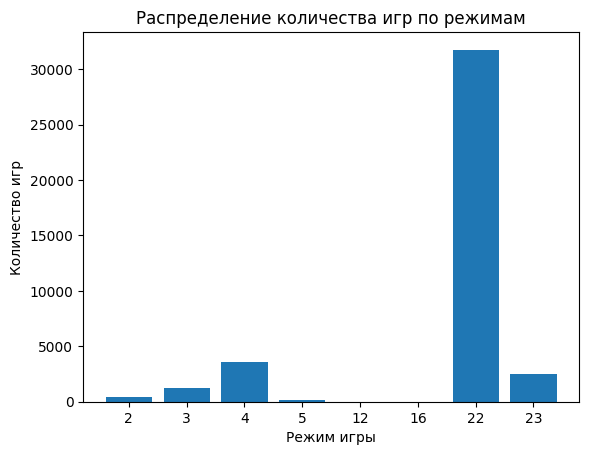

In [8]:
# тут EDA, который вы считаете необходимым, например, изучим количество игр в разных режимах

mode_counts = X['game_mode'].value_counts().sort_index()

plt.bar(mode_counts.index.astype(str), mode_counts.values)
plt.xlabel('Режим игры')
plt.ylabel('Количество игр')
plt.title('Распределение количества игр по режимам')
plt.show()



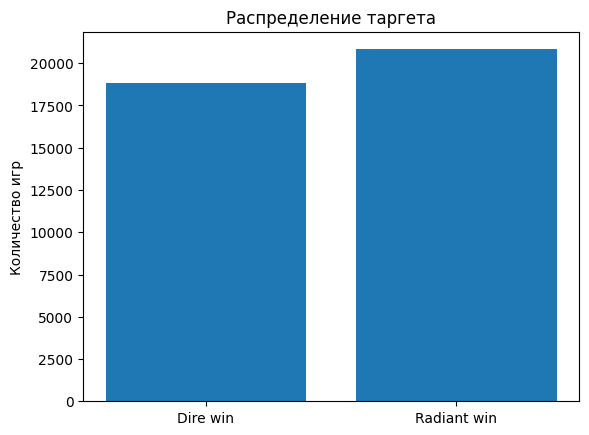

In [9]:
# посмотрим распределение таргета

target = y.value_counts().sort_index()
plt.bar(['Dire win', 'Radiant win'], target.values)
plt.ylabel('Количество игр')
plt.title('Распределение таргета')
plt.show()


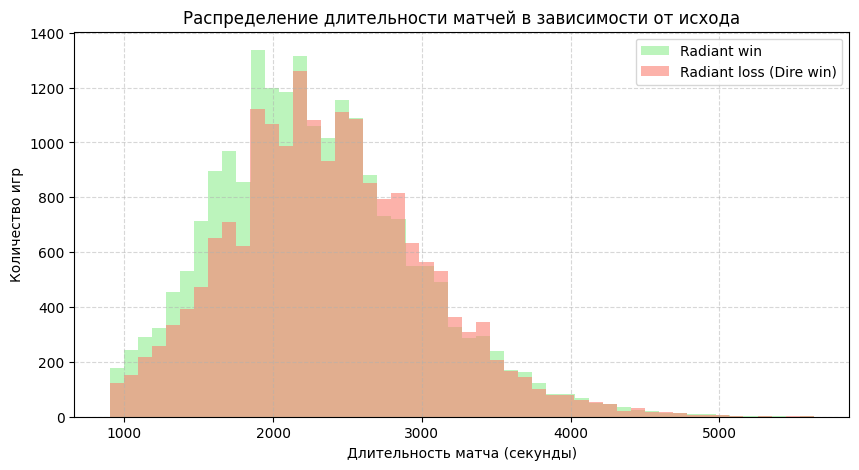

In [10]:
... # далее ваш EDA - все, что вы считаете необходимым

plt.figure(figsize=(10, 5))
plt.hist(train_targets[y == True]['duration'], bins=50, alpha=0.6, label='Radiant win', color='lightgreen')
plt.hist(train_targets[y == False]['duration'], bins=50, alpha=0.6, label='Radiant loss (Dire win)', color='salmon')
plt.xlabel('Длительность матча (секунды)')
plt.ylabel('Количество игр')
plt.title('Распределение длительности матчей в зависимости от исхода')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


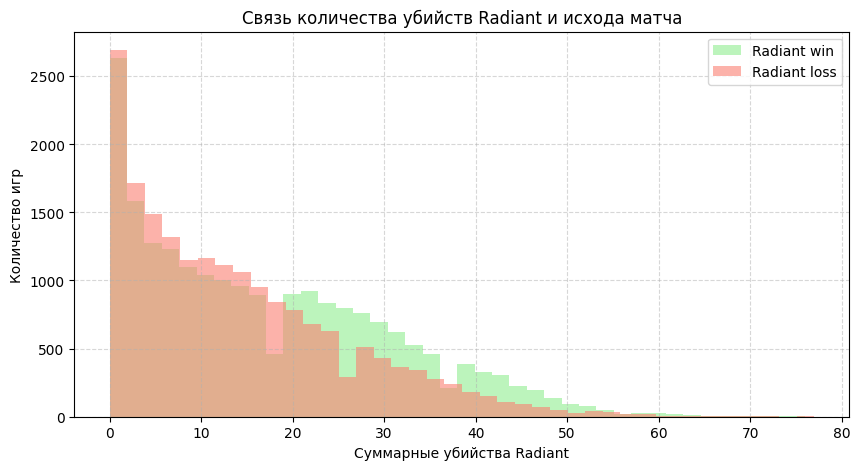

In [11]:
# Суммарные киллы Radiant (r1_kills + r2_kills + ... + r5_kills)
radiant_kill_cols = [f'r{i}_kills' for i in range(1, 6)]
X['radiant_kills_total'] = X[radiant_kill_cols].sum(axis=1)

plt.figure(figsize=(10, 5))
plt.hist(X[y == True]['radiant_kills_total'], bins=40, alpha=0.6, label='Radiant win', color='lightgreen')
plt.hist(X[y == False]['radiant_kills_total'], bins=40, alpha=0.6, label='Radiant loss', color='salmon')
plt.xlabel('Суммарные убийства Radiant')
plt.ylabel('Количество игр')
plt.title('Связь количества убийств Radiant и исхода матча')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


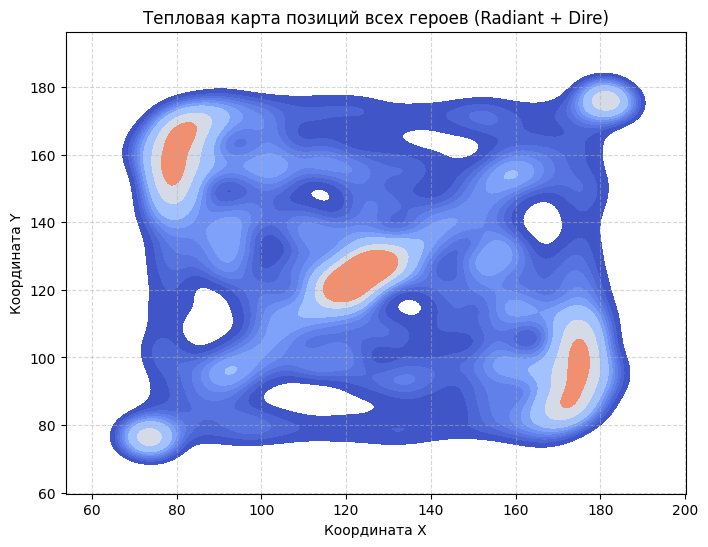

In [12]:

# Собираем координаты всех 10 героев
x_columns = [f'{team}{i}_x' for team in ['r', 'd'] for i in range(1, 6)]
y_columns = [f'{team}{i}_y' for team in ['r', 'd'] for i in range(1, 6)]

# Объединяем в один список координат
all_x = pd.concat([X[col] for col in x_columns], ignore_index=True)
all_y = pd.concat([X[col] for col in y_columns], ignore_index=True)

# Строим тепловую карту
plt.figure(figsize=(8, 6))
sns.kdeplot(x=all_x, y=all_y, cmap="coolwarm", fill=True, thresh=0.05)
plt.title('Тепловая карта позиций всех героев (Radiant + Dire)')
plt.xlabel('Координата X')
plt.ylabel('Координата Y')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



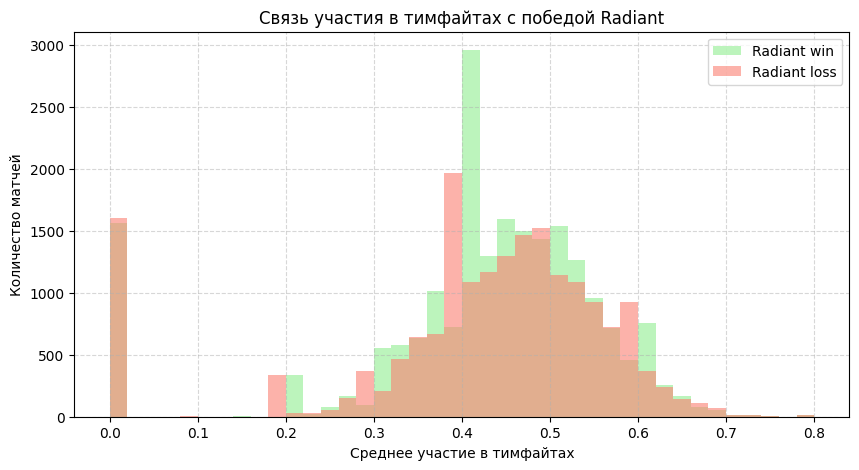

In [13]:
tf_cols = [f'r{i}_teamfight_participation' for i in range(1, 6)]
X['radiant_tf_participation_avg'] = X[tf_cols].mean(axis=1)

plt.figure(figsize=(10, 5))
plt.hist(X[y == True]['radiant_tf_participation_avg'], bins=40, alpha=0.6, label='Radiant win', color='lightgreen')
plt.hist(X[y == False]['radiant_tf_participation_avg'], bins=40, alpha=0.6, label='Radiant loss', color='salmon')
plt.xlabel('Среднее участие в тимфайтах')
plt.ylabel('Количество матчей')
plt.title('Связь участия в тимфайтах с победой Radiant')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


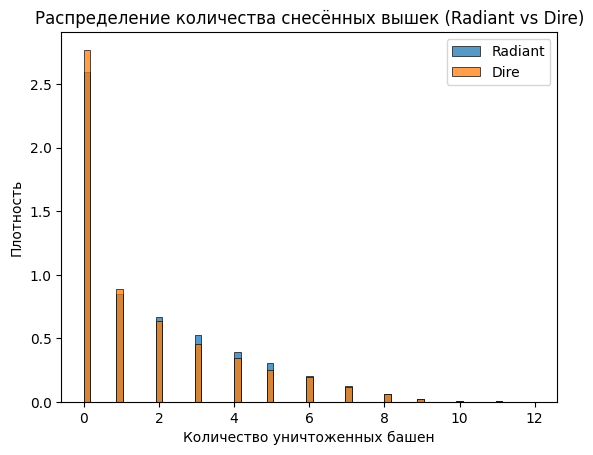

In [14]:

radiant_tower_cols = [f'r{i}_towers_killed' for i in range(1, 6)]
dire_tower_cols = [f'd{i}_towers_killed' for i in range(1, 6)]

# Суммарные вышки на матч
X['radiant_towers'] = X[radiant_tower_cols].sum(axis=1)
X['dire_towers'] = X[dire_tower_cols].sum(axis=1)

sns.histplot(X['radiant_towers'], label='Radiant', stat='density')
sns.histplot(X['dire_towers'],label='Dire', stat='density')
plt.title('Распределение количества снесённых вышек (Radiant vs Dire)')
plt.xlabel('Количество уничтоженных башен')
plt.ylabel('Плотность')
plt.legend()
plt.show()


In [15]:
# don't know both ml AND dota2? pick a struggle, man
# я хз что такое варды. пока.

# Обучим CatBoost на чистых данных и посмотрим на метрики

In [23]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = CatBoostClassifier(
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]
    
    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall CAT OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8180, Accuracy score: 0.7299
FOLD 1, Validation ROC-AUC score: 0.8043, Accuracy score: 0.7157
FOLD 2, Validation ROC-AUC score: 0.8007, Accuracy score: 0.7078
FOLD 3, Validation ROC-AUC score: 0.8052, Accuracy score: 0.7185
FOLD 4, Validation ROC-AUC score: 0.8068, Accuracy score: 0.7214

Overall CAT OOF ROC-AUC: 0.8070, OOF Accuracy: 0.7186


# Генерация фичей (5 баллов)

Генерация фичей является одной из важнейших частей построения пайплайна машинного обучения. В данной части вам предлагается придумать и сгенерировать полезные фичи для модели. Важно: они должны повысить метрику. В качестве примера сгенерированы статистические фичи. Вы можете не использовать их, если не считаете их нужными.

In [24]:
def fe(data):
    for c in [
        'kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 
        'health', 'max_health', 'max_mana', 'level', 'x', 'y', 
        'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
        'firstblood_claimed', 'teamfight_participation', 'towers_killed', 
        'roshans_killed', 'obs_placed', 'sen_placed'
    ]:
        r_columns = [f'r{i}_{c}' for i in range(1, 6)]
        d_columns = [f'd{i}_{c}' for i in range(1, 6)]

        eps = 1e-8 # избегаем деления на 0
        
        data['r_total_' + c] = data[r_columns].sum(1)
        data['d_total_' + c] = data[d_columns].sum(1)
        data['total_' + c + '_ratio'] = data['r_total_' + c] / (data['d_total_' + c] + eps)
        data['total_' + c + '_diff'] = data['r_total_' + c] - data['d_total_' + c]
        
        data['r_mean_' + c] = data[r_columns].mean(1)
        data['d_mean_' + c] = data[d_columns].mean(1)
        data['r_std_' + c] = data[r_columns].std(1)
        data['d_std_' + c] = data[d_columns].std(1)
        data['r_median_' + c] = data[r_columns].median(1)
        data['d_median_' + c] = data[d_columns].median(1)
        data['r_max_' + c] = data[r_columns].max(1)
        data['d_max_' + c] = data[d_columns].max(1)
        data['r_min_' + c] = data[r_columns].min(1)
        data['d_min_' + c] = data[d_columns].min(1)
        data['r_range_' + c] = data[r_columns].max(axis=1) - data[r_columns].min(1)
        data['d_range_' + c] = data[d_columns].max(axis=1) - data[d_columns].min(1)




    return data

# Теперь обучим CatBoost на данных с новыми фичами и посмотрим на метрики

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train)
    X_valid = fe(X_valid)

    model = CatBoostClassifier(
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]
    
    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8365, Accuracy score: 0.7439
FOLD 1, Validation ROC-AUC score: 0.8184, Accuracy score: 0.7290
FOLD 2, Validation ROC-AUC score: 0.8194, Accuracy score: 0.7307


# Обработка категориальных фичей средствами CatBoost

Попробуем подать категориальные фичи в модель через cat_features.

In [ ]:
# выделим очевидные категориальные фичи - вы можете попробовать выделить больше / сгенерировать новые или же вовсе отказаться от этой идеи
cats = ['game_mode', 'lobby_type']

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train)
    X_valid = fe(X_valid)

    model = CatBoostClassifier(
        cat_features=cats,
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]
    
    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall CAT w/ FE OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

# Отбор фичей (5 баллов)

Возможно, на этапе генерации фичей вы решили прибегнуть к автоматической генерации (если нет, то советую обратить внимание на библиотеку OpenFE), или же просто генерировали все подряд. Также, возможно, исходные данные содержали бесполезные и шумные фичи.

Вам предлагается исследовать это и оставить только те фичи, которые вы считаете важными.

Идеи для отбора фичей: 
- по feature importance
- по permutation importance
- по shap values
- recursive feature elimination
- sequential feature selection

Также обратите внимание на гайд от catboost: https://github.com/catboost/catboost/blob/master/catboost/tutorials/feature_selection/select_features_tutorial.ipynb

In [ ]:
# бейзлайн: используем встроенные инструменты catboost - вы можете работать с ним или обратиться к другим инструментам
# здесь нужно быть аккуратным, ведь удаление фичей всегда может привести к падению скора 
# необходимо подобрать грамотный подход, а это можно сделать только путем экспериментов

from sklearn.model_selection import train_test_split

model = CatBoostClassifier(
    cat_features=cats,
    random_state=69,
    verbose=0,
    thread_count=4
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

X_train = fe(X_train)
X_test = fe(X_test)

train_pool = Pool(X_train, y_train, cat_features=cats)
test_pool = Pool(X_test, y_test, cat_features=cats)

summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select=list(range(X_train.shape[1])),
    num_features_to_select=300, # количество фичей, которое хотим отобрать - один из самых важных параметров
    algorithm='RecursiveByShapValues', # точно стоит поиграться с выбором алгоритма - важный параметр !!!
    steps=5, # количество шагов
    shap_calc_type=None,
    train_final_model=False,
    verbose=None,
    logging_level=None,
    plot=True
)


selected_features = summary['selected_features'] # отобранные фичи

# Обучим модель на отобранных и фичах и посмотрим на метрики

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    model = CatBoostClassifier(
        cat_features=cats,
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]
    
    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall CAT w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

# Блендинг: добавим XGBoost и LightGBM

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_lgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    # lgbm требует указания категориальных фичей как 'category'
    for col in cats:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

    model = lgb.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=69,
        n_jobs=4,
        metric='auc',
        early_stopping_round=100,
        verbosity=-1
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        categorical_feature=cats
    )

    y_pred = model.predict_proba(X_valid)[:, 1]
    
    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_lgb[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_lgb)
oof_accuracy = accuracy_score(y, oof_lgb > 0.5)
print(f'\nOverall LGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_xgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    # xgb требует указания категориальных фичей как 'category'
    for col in cats:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

    cat_columns = [X_train.columns.get_loc(col) for col in cats]
    
    model = XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=69,
        n_jobs=4,
        eval_metric='auc',
        early_stopping_rounds=100,
        use_label_encoder=False,
        enable_categorical=True, 
        tree_method='hist'
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    y_pred = model.predict_proba(X_valid)[:, 1]
    
    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_xgb[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_xgb)
oof_accuracy = accuracy_score(y, oof_xgb > 0.5)
print(f'\nOverall XGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

In [ ]:
# сблендим предсказания и посмотрим на метрики

oof_blend = (oof_cat + oof_lgb + oof_xgb) / 3

oof_roc_auc = roc_auc_score(y, oof_blend)
oof_accuracy = accuracy_score(y, oof_blend > 0.5)
print(f'\nOverall BLEND w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

# Подбор гиперпараметров (15 баллов)

Для изучения того, какие гиперпараметры доступны у модели для выбора можно использовать '? ModelName'
Определитесь с тем, какие гиперпараметры вы хотите оптимизировать и укажите их в objective. Выполните поиск гиперпараметров с Optuna

In [ ]:
# ? CatBoostClassifier

In [ ]:
# ? lgb.LGBMClassifier

In [ ]:
# ? XGBClassifier

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'task_type': 'CPU',
        'random_state': 69,
        'verbose': 0,
        # добавьте сюда прочие гиперпараметры, к примеру l2_leaf_reg, random_strength, bagging_temperature, ...
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
    }
    
    if 'cats' in globals():
        params['cat_features'] = cats
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
    oof_cat = np.zeros(len(X))
    
    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        X_train = fe(X_train).iloc[:, selected_features]
        X_valid = fe(X_valid).iloc[:, selected_features]
        
        model = CatBoostClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            early_stopping_rounds=100,
            verbose=0
        )
        
        y_pred = model.predict_proba(X_valid)[:, 1]
        oof_cat[valid_idx] = y_pred

    oof_roc_auc = roc_auc_score(y, oof_cat)
    
    return oof_roc_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

cat_params = study.best_params
cat_params

In [ ]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'random_state': 69,
        'n_jobs': 4,
        'verbosity': -1,
        'early_stopping_rounds': 100,
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        # добавьте сюда прочие гиперпараметры, к примеру num_leaves, min_child_samples, subsample, ...
    }
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
    oof_lgb = np.zeros(len(X))
    
    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        X_train = fe(X_train).iloc[:, selected_features]
        X_valid = fe(X_valid).iloc[:, selected_features]
        
        for col in cats:
            X_train[col] = X_train[col].astype('category')
            X_valid[col] = X_valid[col].astype('category')
        
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            categorical_feature=cats,
        )
        
        y_pred = model.predict_proba(X_valid)[:, 1]
        oof_lgb[valid_idx] = y_pred

    oof_roc_auc = roc_auc_score(y, oof_lgb)
    
    return oof_roc_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

lgb_params = study.best_params
lgb_params

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'eval_metric': 'auc',
        'early_stopping_rounds': 100,
        'use_label_encoder': False,
        'enable_categorical': True,
        'tree_method': 'hist',
        'random_state': 69,
        'n_jobs': 4,
        'gamma': trial.suggest_float('gamma', 0, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        # добавьте сюда прочие гиперпараметры, к примеру gamma, min_child_weight, subsample, ...
    }
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
    oof_xgb = np.zeros(len(X))
    
    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        

        X_train = fe(X_train).iloc[:, selected_features]
        X_valid = fe(X_valid).iloc[:, selected_features]
        
        for col in cats:
            X_train[col] = X_train[col].astype('category')
            X_valid[col] = X_valid[col].astype('category')
        
        model = XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )
        
        y_pred = model.predict_proba(X_valid)[:, 1]
        oof_xgb[valid_idx] = y_pred

    oof_roc_auc = roc_auc_score(y, oof_xgb)
    
    return oof_roc_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

xgb_params = study.best_params

# Обучим модели с новыми гиперпараметрами

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    model = CatBoostClassifier(
        **cat_params,
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]
    
    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall Tuned CAT w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_lgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    # lgbm требует указания категориальных фичей как 'category'
    for col in cats:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

    final_params = {
        **lgb_params,
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'random_state': 69,
        'n_jobs': 4,
        'verbosity': -1,
        'early_stopping_round': 100
    }

    model = lgb.LGBMClassifier(**final_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        categorical_feature=cats
    )

    y_pred = model.predict_proba(X_valid)[:, 1]
    
    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_lgb[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_lgb)
oof_accuracy = accuracy_score(y, oof_lgb > 0.5)
print(f'\nOverall Tuned LGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_xgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    # xgb требует указания категориальных фичей как 'category'
    for col in cats:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

    cat_columns = [X_train.columns.get_loc(col) for col in cats]

    final_params = {
        **xgb_params,
        'eval_metric': 'auc',
        'early_stopping_rounds': 100,
        'use_label_encoder': False,
        'enable_categorical': True,
        'tree_method': 'hist',
        'random_state': 69,
        'n_jobs': 4
    }

    model = XGBClassifier(**final_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    y_pred = model.predict_proba(X_valid)[:, 1]
    
    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_xgb[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_xgb)
oof_accuracy = accuracy_score(y, oof_xgb > 0.5)
print(f'\nOverall Tuned XGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

In [ ]:
# сблендим предсказания и посмотрим на метрики

oof_blend = (oof_cat + oof_lgb + oof_xgb) / 3

oof_roc_auc = roc_auc_score(y, oof_blend)
oof_accuracy = accuracy_score(y, oof_blend > 0.5)
print(f'\nOverall Tuned BLEND w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

# Итоговая важность фичей

In [ ]:
# изучите итоговые важности фичей моделей catboost, lgbm, xgb (используйте обычный feature importance)
# можно использовать модели с последнего фолда
# если хочется более точно - можно посчитать важности на каждом фолде и усреднить (это опционально)

# ваш код:
...